In [4]:
!pip install pandas tqdm opencv-python kagglehub

import os
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm
import cv2
import shutil
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
base_path = kagglehub.dataset_download("andrewmvd/hard-hat-detection")

images_path = os.path.join(base_path, "images")
annotations_path = os.path.join(base_path, "annotations")

print("Images path:", images_path)
print("Annotations path:", annotations_path)

Using Colab cache for faster access to the 'hard-hat-detection' dataset.
Images path: /kaggle/input/hard-hat-detection/images
Annotations path: /kaggle/input/hard-hat-detection/annotations


In [6]:
def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(images_path, image_name)

    boxes = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        boxes.append([image_path, label, xmin, ymin, xmax, ymax])
    return boxes

In [7]:
print("Parsing annotations...")

data = []
for xml_file in tqdm(os.listdir(annotations_path)):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(annotations_path, xml_file)
        data.extend(parse_voc_annotation(xml_path))

df = pd.DataFrame(data, columns=["image_path", "label", "xmin", "ymin", "xmax", "ymax"])
print("\n✅ Parsed", len(df), "objects.")
df.head()

Parsing annotations...


100%|██████████| 5000/5000 [00:14<00:00, 351.12it/s]



✅ Parsed 25502 objects.


image_path   label  xmin  ymin  \
0  /kaggle/input/hard-hat-detection/images/hard_h...  helmet    90   104   
1  /kaggle/input/hard-hat-detection/images/hard_h...  helmet   109   107   
2  /kaggle/input/hard-hat-detection/images/hard_h...  helmet   310   185   
3  /kaggle/input/hard-hat-detection/images/hard_h...  helmet    90     8   
4  /kaggle/input/hard-hat-detection/images/hard_h...  helmet   109     3   

   xmax  ymax  
0   114   131  
1   133   135  
2   329   208  
3   114    35  
4   133    31

/tmp/ipython-input-670864554.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


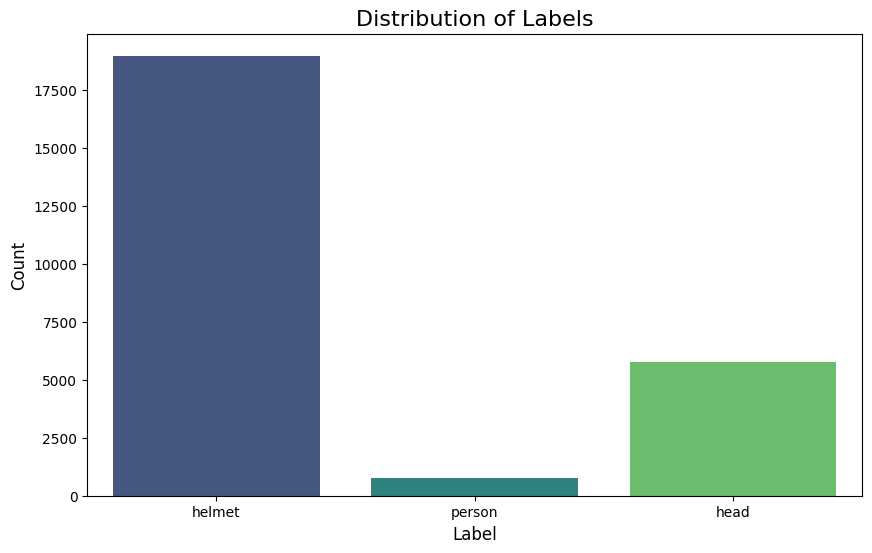

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Labels', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [9]:
output_dir = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)
csv_path = os.path.join(output_dir, "annotations.csv")
df.to_csv(csv_path, index=False)
print(f"✅ CSV file saved at: {csv_path}")

✅ CSV file saved at: /kaggle/working/annotations.csv


In [10]:
create_yolo = True
output_dir = "/kaggle/working/"

if create_yolo:
    yolo_dataset_path = os.path.join(output_dir, "yolo_dataset")
    yolo_images = os.path.join(yolo_dataset_path, "images")
    yolo_labels = os.path.join(yolo_dataset_path, "labels")
    os.makedirs(yolo_images, exist_ok=True)
    os.makedirs(yolo_labels, exist_ok=True)

    def voc_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
        x_center = (xmin + xmax) / 2 / img_w
        y_center = (ymin + ymax) / 2 / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h
        return x_center, y_center, w, h

    print("\nConverting to YOLO format...")
    image_paths = df["image_path"].unique()
    for img_path in tqdm(image_paths):
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w = img.shape[:2]
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(yolo_labels, label_name)

        with open(label_path, "w") as f:
            for _, row in df[df["image_path"] == img_path].iterrows():
                label_lower = row["label"].lower()
                if label_lower == "helmet":
                    class_id = 0
                elif label_lower == "head":
                    class_id = 1
                elif label_lower == "person":
                    class_id = 2
                else:
                    continue

                x, y, w_rel, h_rel = voc_to_yolo(
                    row["xmin"], row["ymin"], row["xmax"], row["ymax"], w, h
                )
                f.write(f"{class_id} {x:.6f} {y:.6f} {w_rel:.6f} {h_rel:.6f}\n")

        shutil.copy(img_path, os.path.join(yolo_images, img_name))

    print("\n✅ YOLO dataset created at:", yolo_dataset_path)
else:
    print("Skipped YOLO conversion.")


Converting to YOLO format...


100%|██████████| 5000/5000 [01:29<00:00, 55.88it/s]


✅ YOLO dataset created at: /kaggle/working/yolo_dataset


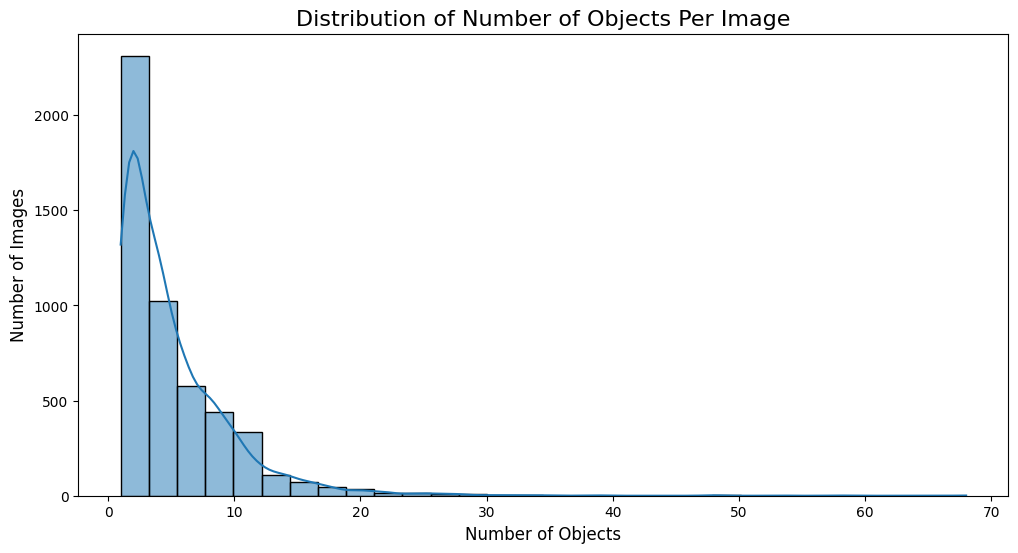

In [11]:
objects_per_image = df.groupby('image_path').size()

plt.figure(figsize=(12, 6))
sns.histplot(objects_per_image, bins=30, kde=True)
plt.title('Distribution of Number of Objects Per Image', fontsize=16)
plt.xlabel('Number of Objects', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.show()

/tmp/ipython-input-1398043224.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='area', data=df, palette='viridis')


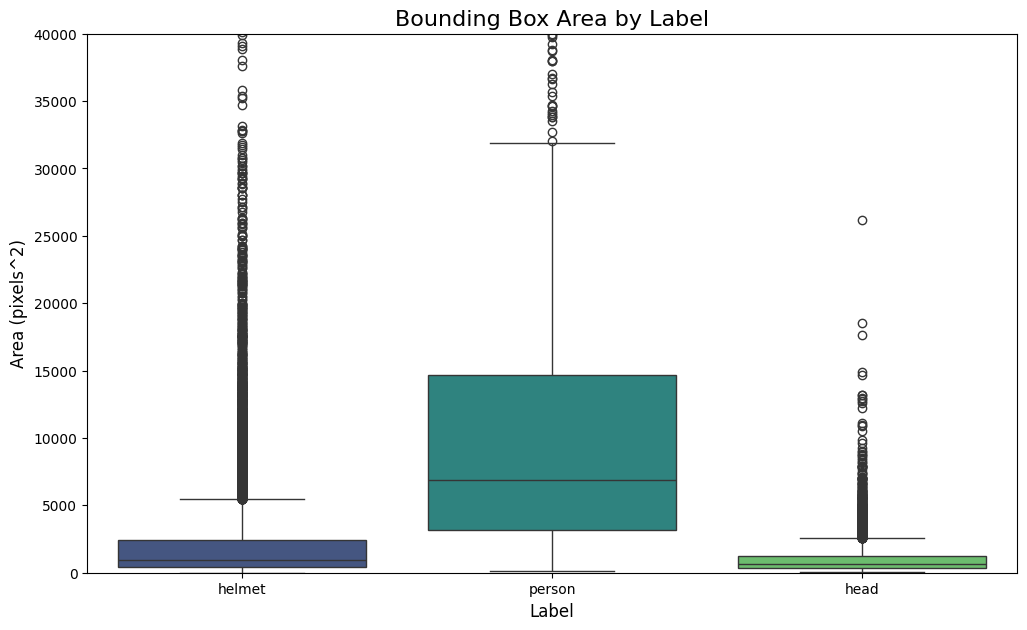

In [12]:
df['area'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])

plt.figure(figsize=(12, 7))
sns.boxplot(x='label', y='area', data=df, palette='viridis')
plt.title('Bounding Box Area by Label', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Area (pixels^2)', fontsize=12)
plt.ylim(0, 40000)
plt.show()

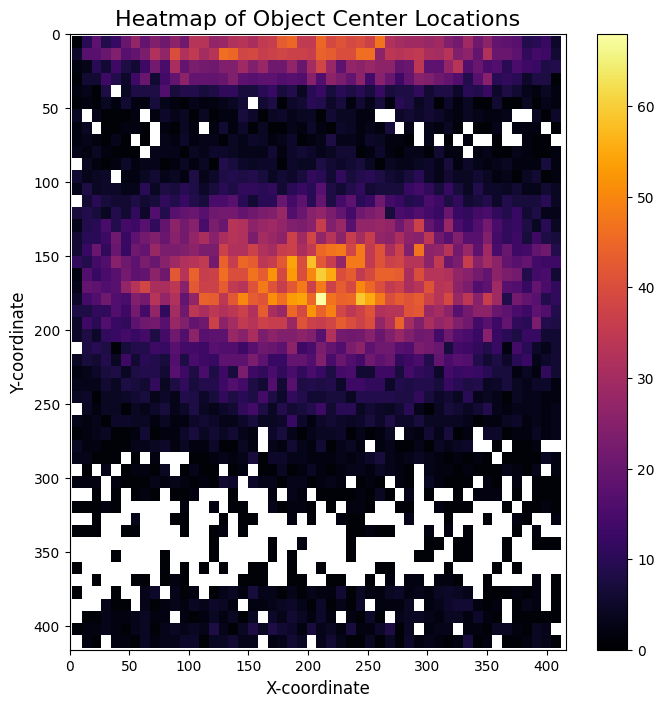

In [13]:
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2
plt.figure(figsize=(8, 8))
sns.histplot(x=df['x_center'], y=df['y_center'], bins=50, cmap='inferno', cbar=True)
plt.title('Heatmap of Object Center Locations', fontsize=16)
plt.xlabel('X-coordinate', fontsize=12)
plt.ylabel('Y-coordinate', fontsize=12)
plt.xlim(0, 416)
plt.ylim(416, 0)
plt.show()

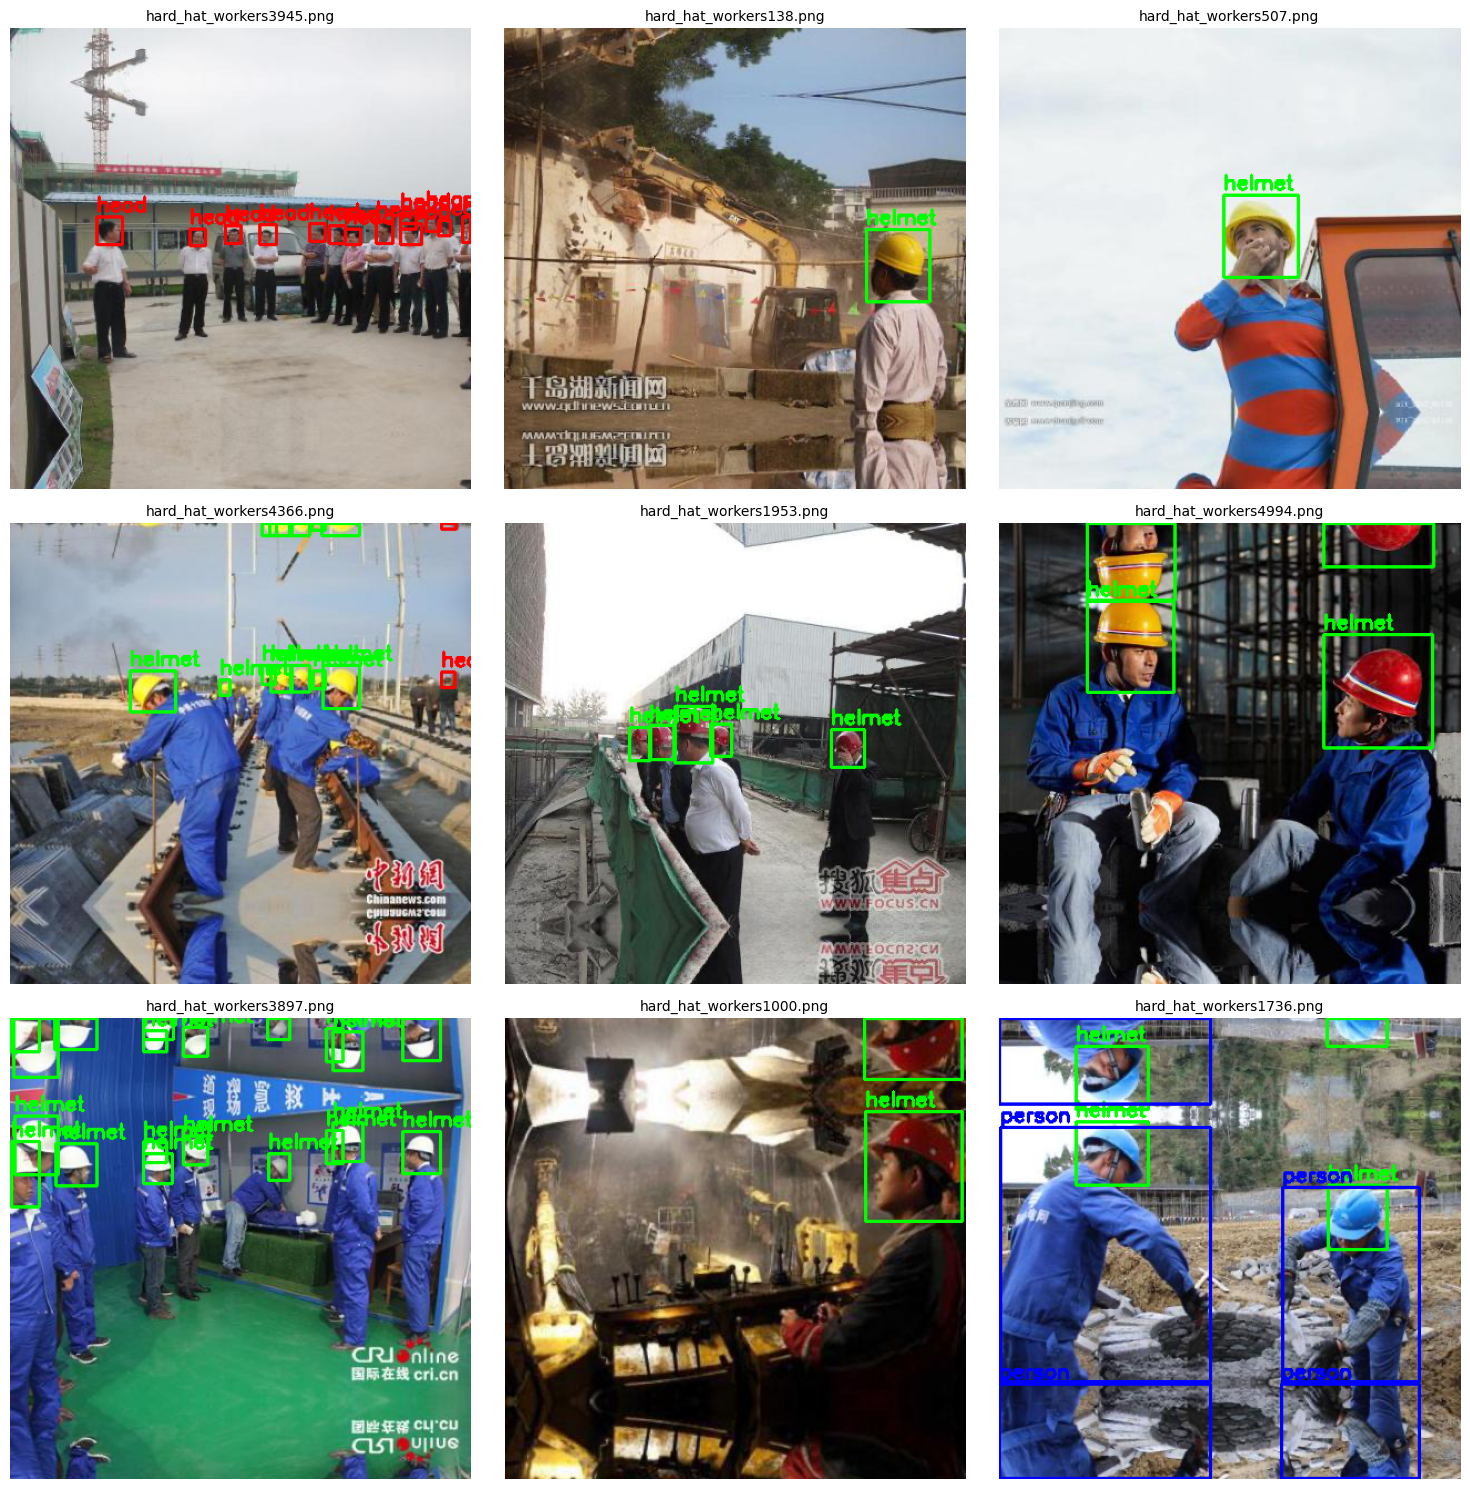

In [14]:
def show_image_grid(df, num_images=9):
    sample_paths = df['image_path'].drop_duplicates().sample(num_images, random_state=42)
    color_map = {
        "helmet": (0, 255, 0),
        "head": (255, 0, 0),
        "person": (0, 0, 255)
    }

    plt.figure(figsize=(15, 15))
    for i, image_path in enumerate(sample_paths):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        boxes = df[df["image_path"] == image_path]

        for _, row in boxes.iterrows():
            label = row["label"]
            color = color_map.get(label, (255, 255, 255))
            cv2.rectangle(img, (row["xmin"], row["ymin"]), (row["xmax"], row["ymax"]), color, 2)
            cv2.putText(img, label, (row["xmin"], row["ymin"] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(image_path), fontsize=10)

    plt.tight_layout()
    plt.show()

show_image_grid(df)

Previewing: /kaggle/input/hard-hat-detection/images/hard_hat_workers429.png


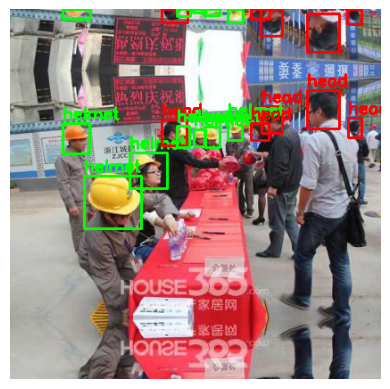

In [15]:
def show_image_with_boxes(image_path, df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = df[df["image_path"] == image_path]

    for _, row in boxes.iterrows():
        label = row["label"]
        color = (0, 0, 255)

        if label == "helmet":
            color = (0, 255, 0)
        elif label == "head":
            color = (255, 0, 0)

        cv2.rectangle(img, (row["xmin"], row["ymin"]), (row["xmax"], row["ymax"]), color, 2)
        cv2.putText(img, label, (row["xmin"], row["ymin"] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    plt.imshow(img)
    plt.axis("off")
    plt.show()


sample = df.sample(1)["image_path"].values[0]
print("Previewing:", sample)
show_image_with_boxes(sample, df)

In [16]:
%%writefile /kaggle/working/data.yaml
path: /kaggle/working/yolo_dataset/
train: images
val: images

names:
  0: helmet
  1: head
  2: person

Writing /kaggle/working/data.yaml


In [17]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.9 MB/s eta 0:00:00


In [18]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
results = model.train(data='/kaggle/working/data.yaml', epochs=10, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

In [20]:
from ultralytics import YOLO
model = YOLO('runs/detect/train/weights/best.pt')
model.export(format='tflite')
print("\n✅ Your custom model has been exported to 'best_float32.tflite'!")

Ultralytics 8.3.214 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (6.0 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 18.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


TensorFlow SavedModel: starting export with tensorflow 2.19.0...
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.np

In [21]:
%%writefile /kaggle/working/labels.txt
helmet
head
person

Writing /kaggle/working/labels.txt


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00


In [1]:
!pip install gradio -q

In [ ]:
import gradio as gr
from ultralytics import YOLO
import cv2
import numpy as np

# --- 1. Load the TFLite model and labels ---
try:
    model = YOLO('best_float32.tflite')
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure 'best_float32.tflite' is uploaded to your Colab session.")

# Load class names from labels.txt
try:
    with open('labels.txt', 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
except FileNotFoundError:
    print("Error: 'labels.txt' not found. Please upload the labels file.")
    class_names = []

# Define colors for each label (OpenCV uses BGR format)
color_map = {
    "helmet": (0, 255, 0),  # Green
    "head": (0, 0, 255),    # Red
    "person": (255, 0, 0)   # Blue
}

# --- 2. Define the new prediction function ---
def predict_image(image):
    """
    Runs YOLOv8 TFLite inference and manually draws bounding boxes.
    """
    # The input 'image' from Gradio is an RGB NumPy array.
    # We make a copy and convert it to BGR for OpenCV drawing.
    img_to_draw = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Run inference
    results = model.predict(source=image, conf=0.25)
    result = results[0] # Get the first result

    # Iterate over each detected box
    for box in result.boxes:
        # Get coordinates, class ID, and confidence
        coords = box.xyxy[0].cpu().numpy().astype(int)
        class_id = int(box.cls[0].cpu().numpy())
        confidence = box.conf[0].cpu().numpy()

        # Get the class name and color for the box
        class_name = class_names[class_id]
        color = color_map.get(class_name, (255, 255, 255)) # Default to white

        # Draw the bounding box on the image
        x1, y1, x2, y2 = coords
        cv2.rectangle(img_to_draw, (x1, y1), (x2, y2), color, 2)

        # Create and draw the label text with a background
        label = f"{class_name} {confidence:.2f}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        cv2.rectangle(img_to_draw, (x1, y1 - h - 10), (x1 + w, y1), color, -1)
        cv2.putText(img_to_draw, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Convert the annotated BGR image back to RGB for Gradio display
    annotated_image_rgb = cv2.cvtColor(img_to_draw, cv2.COLOR_BGR2RGB)

    return annotated_image_rgb

# --- 3. Create and launch the Gradio interface ---
with gr.Blocks() as iface:
    gr.Markdown("# ⛑️ Hard Hat Detection (TFLite Model)")
    gr.Markdown("Upload an image to detect helmets (green), heads without helmets (red), and people (blue).")

    with gr.Row():
        image_input = gr.Image(type="numpy", label="Upload Image")
        image_output = gr.Image(type="numpy", label="Detected Objects")

    btn = gr.Button("Detect Objects")
    btn.click(fn=predict_image, inputs=image_input, outputs=image_output)

# Launch the app. `share=True` creates a public, shareable link.
iface.launch(share=True, debug=True)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://58f3284e077e4fd578.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Loading best_float32.tflite for TensorFlow Lite inference...



/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


0: 640x640 7 helmets, 136.0ms
Speed: 75.7ms preprocess, 136.0ms inference, 79.7ms postprocess per image at shape (1, 3, 640, 640)
